# Segmentation notebook

In this tutorial, we will solve a segmentation task with **BatchFlow**. Apart from the main possibilities of our library covered in our previous [classification tutorial](https://github.com/analysiscenter/batchflow/blob/master/examples/00_project_from_scratch.ipynb), we will show you how to use the model imported from the another library with the BatchFlow config, address the problem with exceeding GPU memory using the **microbatch** technique, and also demonstrate several segmentation tricks which can help in your research.

**Content**:
* [Dataset loading and setting the global parameters](#load_dataset)
* [Model configuration](#model)
* [Train pipeline definition](#train_pipeline)
* [Validation pipeline definition](#val_pipeline)
* [Plotting images from the pipeline](#plot)
* [Training stage](#train_stage)
* [Inference stage](#inference)
* [Conclusion](#conclusion)

In [1]:
# Necessary imports
import os
import sys
sys.path.insert(0, './batchflow/')
sys.path.insert(0, './segmentation_models.pytorch/')

import warnings
warnings.filterwarnings('ignore')

import numpy as np
from torchinfo import summary

from matplotlib import pyplot as plt
plt.style.use('ggplot')

import segmentation_models_pytorch as smp

from nbtools import pylint_notebook

from batchflow import B, P, R, V, Pipeline, set_gpus
from batchflow.plotter import plot
from batchflow.models.torch import TorchModel
from batchflow.opensets.pascal import PascalSegmentation

_ = set_gpus(1)

`CUDA_VISIBLE_DEVICES` set to "6"


In [2]:
# Set global parameters
IMAGE_SHAPE = (512, 512)
NUM_EPOCHS = 100
FREQUENCY = 20
BATCH_SIZE = 128
MICRO_BATCH_SIZE = 32

<a id='load_dataset'></a>
## Dataset loading and setting the global parameters

In order to show the solution of the segmentation task, the well-known [**PASCAL VOC 2012**](http://host.robots.ox.ac.uk/pascal/VOC/voc2012/) dataset is used. It contains 1464 and 1449 labeled images with 21 classes for training and validation, respectively.\
The Pascal dataset is already in BatchFlow, so you can simply download it using the `PascalSegmentation` class.

In [3]:
dataset = PascalSegmentation()
print('Train dataset: ', len(dataset.train))
print('Val dataset: ', len(dataset.test))

# Make train dataset bigger
dataset.split(shares=0.9, shuffle=1)
print('New train dataset: ', len(dataset.train))
print('New val dataset: ', len(dataset.test))

Train dataset:  1464
Val dataset:  1449
New train dataset:  2622
New val dataset:  291


Let's take a look at the Pascal dataset more closely 

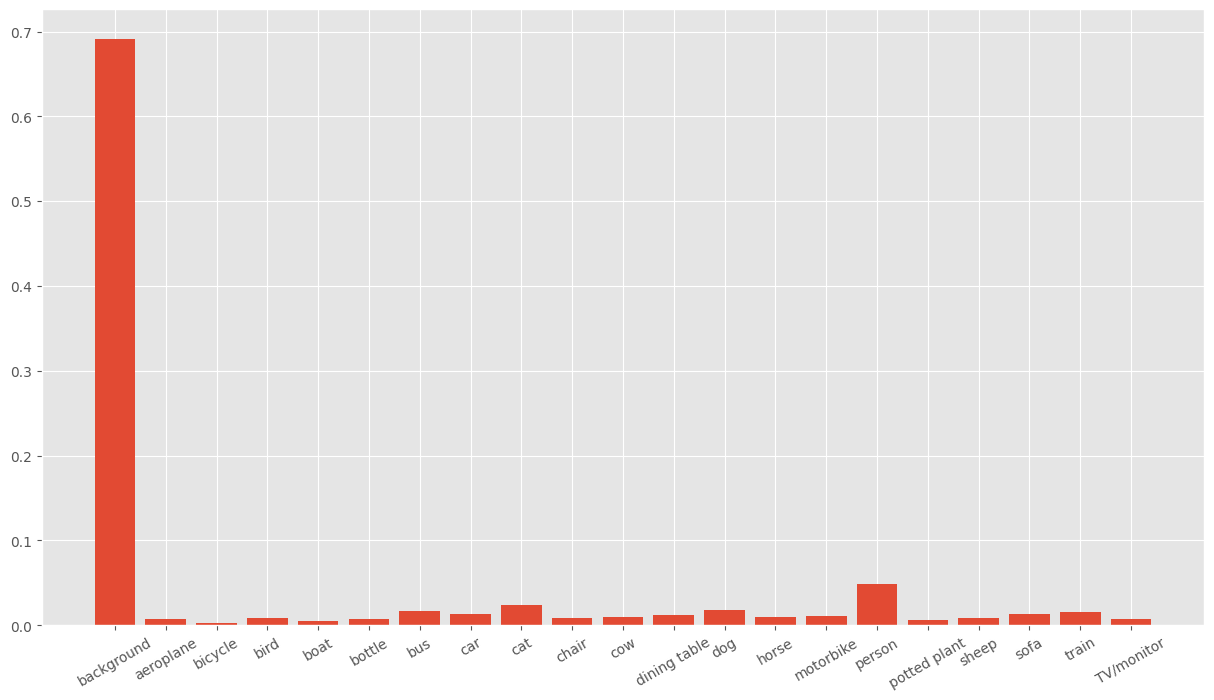

In [4]:
batch = dataset.next_batch(batch_size=len(dataset.train), shuffle=True)

# Count number of unique labels in masks 
unique_labels = np.zeros(256, dtype=int)
for mask in batch.labels:
    mask = np.array(mask)
    labels, counts = np.unique(mask, return_counts=True)
    unique_labels[labels] += counts
    
unique_labels = unique_labels / unique_labels.sum()
nonzero_labels = unique_labels.nonzero()
unique_labels = unique_labels[nonzero_labels]

# Plot barplot without label 255 
fig, ax = plt.subplots(figsize=(15, 8))
ax.bar(nonzero_labels[0][:-1], unique_labels[:-1])
ax.set_xticks(np.arange(21))
ax.set_xticklabels(dataset.classes, rotation=30)
plt.show()

You could notice that the masks contain label 255. It's a void label used for border regions and also to mask difficult objects. Also, there is a high background imbalance. 
We will address these two problems a bit later.

<a id='model'></a>
## Model configuration

At first, we have to choose the model for our task. In the current tutorial, we will use the **DeepLab** model with a pretrained encoder on the ImageNet dataset from the [repository](https://github.com/qubvel/segmentation_models.pytorch), and we will simply add it to the model config along with other necessary parameters such as optimizer, loss function, etc. 
Alternatively, one can create the DeepLab model or another model via the **model config** like in our previous [tutorial](https://github.com/analysiscenter/batchflow/blob/master/examples/00_project_from_scratch.ipynb).

We will construct the model and the training pipeline by using the tricks from the training protocol from the [DeepLab V3 article](https://arxiv.org/abs/1706.05587):
* We use **resizing images to (512, 512)**.
* We use **'poly'** learning rate decay.
* We use data augmentation by **randomly scaling** images and **randomly left-right flipping**.

In [5]:
deeplab = smp.DeepLabV3(
    encoder_name='resnet50',
    encoder_depth=5,
    encoder_weights='imagenet',
    decoder_channels=256,
    in_channels=3,
    classes=dataset.num_classes      
)

# We can look at out model architecture and number of trainanble parameters using the torchinfo.summary 
summary(input_size=(1, 3, 256, 256), model=deeplab)

Layer (type:depth-idx)                             Output Shape              Param #
DeepLabV3                                          [1, 21, 256, 256]         --
├─ResNetEncoder: 1-1                               [1, 3, 256, 256]          --
│    └─Conv2d: 2-1                                 [1, 64, 128, 128]         9,408
│    └─BatchNorm2d: 2-2                            [1, 64, 128, 128]         128
│    └─ReLU: 2-3                                   [1, 64, 128, 128]         --
│    └─MaxPool2d: 2-4                              [1, 64, 64, 64]           --
│    └─Sequential: 2-5                             [1, 256, 64, 64]          --
│    │    └─Bottleneck: 3-1                        [1, 256, 64, 64]          75,008
│    │    └─Bottleneck: 3-2                        [1, 256, 64, 64]          70,400
│    │    └─Bottleneck: 3-3                        [1, 256, 64, 64]          70,400
│    └─Sequential: 2-6                             [1, 512, 32, 32]          --
│    │    └─Bottlen

As a loss function, we will use simple **CrossEntropy**. We tried to address this problem with **cross entropy loss with weights** or **dice loss** but the results only got worse. You can try out your custom loss and put it in the **model config**.

You could also notice that we use **microbatch** parameter in the model config: due to the GPU capacity, we have to apply the **microbatch** technique in order to handle so 'big' images. Hence, we set this parameter in the model config below, it allows one to make chunks of the original batch (**microbatches**), accumulate their gradients and then make a gradient descent step. 

In [6]:
# The model config 
config = {
    'inputs_shapes': (3, *IMAGE_SHAPE),
    'model': deeplab,
    'device': 'cuda:0',
    'loss': 'ce',
    'optimizer': {'name': 'Adam', 'lr': 1e-4},
    'decay': {
        'name': 'lambda',
        'lr_lambda': lambda epoch: (1.0 - epoch / (NUM_EPOCHS // 10)) ** 0.9, 
        'frequency': len(dataset.train) // BATCH_SIZE * 10
    }, # decrease lr every 10th epoch
    'microbatch': MICRO_BATCH_SIZE
}

<a id='train_pipeline'></a>
## Train pipeline definition 

After the model setting, we have to define a training procedure. We will use it as a sequence of **pipelines**. You can find more information about **BatchFlow pipelines** in the [pipeline tutorial](https://github.com/analysiscenter/batchflow/blob/master/examples/02_pipeline_operations.ipynb).

In [7]:
def replace_void_label(batch):
    """ Replace label 255 with 0 (backgorund). """
    batch.train_labels[batch.train_labels == 255] = 0
    return batch

In [8]:
load_pipeline = (
    Pipeline()
    .resize(size=IMAGE_SHAPE, src='images', dst='images')
    .resize(size=IMAGE_SHAPE, src='labels', dst='train_labels')
    .to_array(channels='first', src='images', dst='images', dtype=np.float32)
    .to_array(channels=None, src='train_labels', dst='train_labels', dtype=np.float32) 
    .replace_void_label(B())
    .multiply(multiplier=1/255, src='images')
)

augmentations_pipeline = (
    Pipeline()
    .scale(factor=P(R([1.2, 1.4, 1.6])), src=['images', 'labels'],
           dst=['images', 'labels'], preserve_shape=True, p=0.5) 
    .flip(mode='lr', src=['images', 'labels'],
          dst=['images', 'labels'], p=0.5)
)

train_model_pipeline = (
    Pipeline()
    .init_model('model', model_class=TorchModel, mode='dynamic', config=config)
    .init_variable('train_loss', [])
    .train_model('model', inputs=B('images'), targets=B('train_labels'),
                 outputs='loss', save_to=V('train_loss', mode='a'))
)

images_pipeline = (augmentations_pipeline + load_pipeline) << dataset.train

main_pipeline = (
    augmentations_pipeline + \
    load_pipeline + \
    train_model_pipeline
) << dataset.train

You can see that our training pipeline consists of the following parts:
* **load_pipeline** - resizes images and makes other preprocessing stuff
* **augmentations_pipeline** - adds augmentations
* **train_model_pipeline** - initializes our model and other variables and trains the model

We also use **images_pipeline** to plot the images from the train dataset.

The letters-shortcuts such as **B**, **V**, etc. are [named expressions](https://analysiscenter.github.io/batchflow/intro/named_expr.html) which allow addressing data only when the pipeline is run.

<a id='plot'></a>
## Plotting images from the pipeline

Now that we have constructed our training pipeline, we can look at the images:

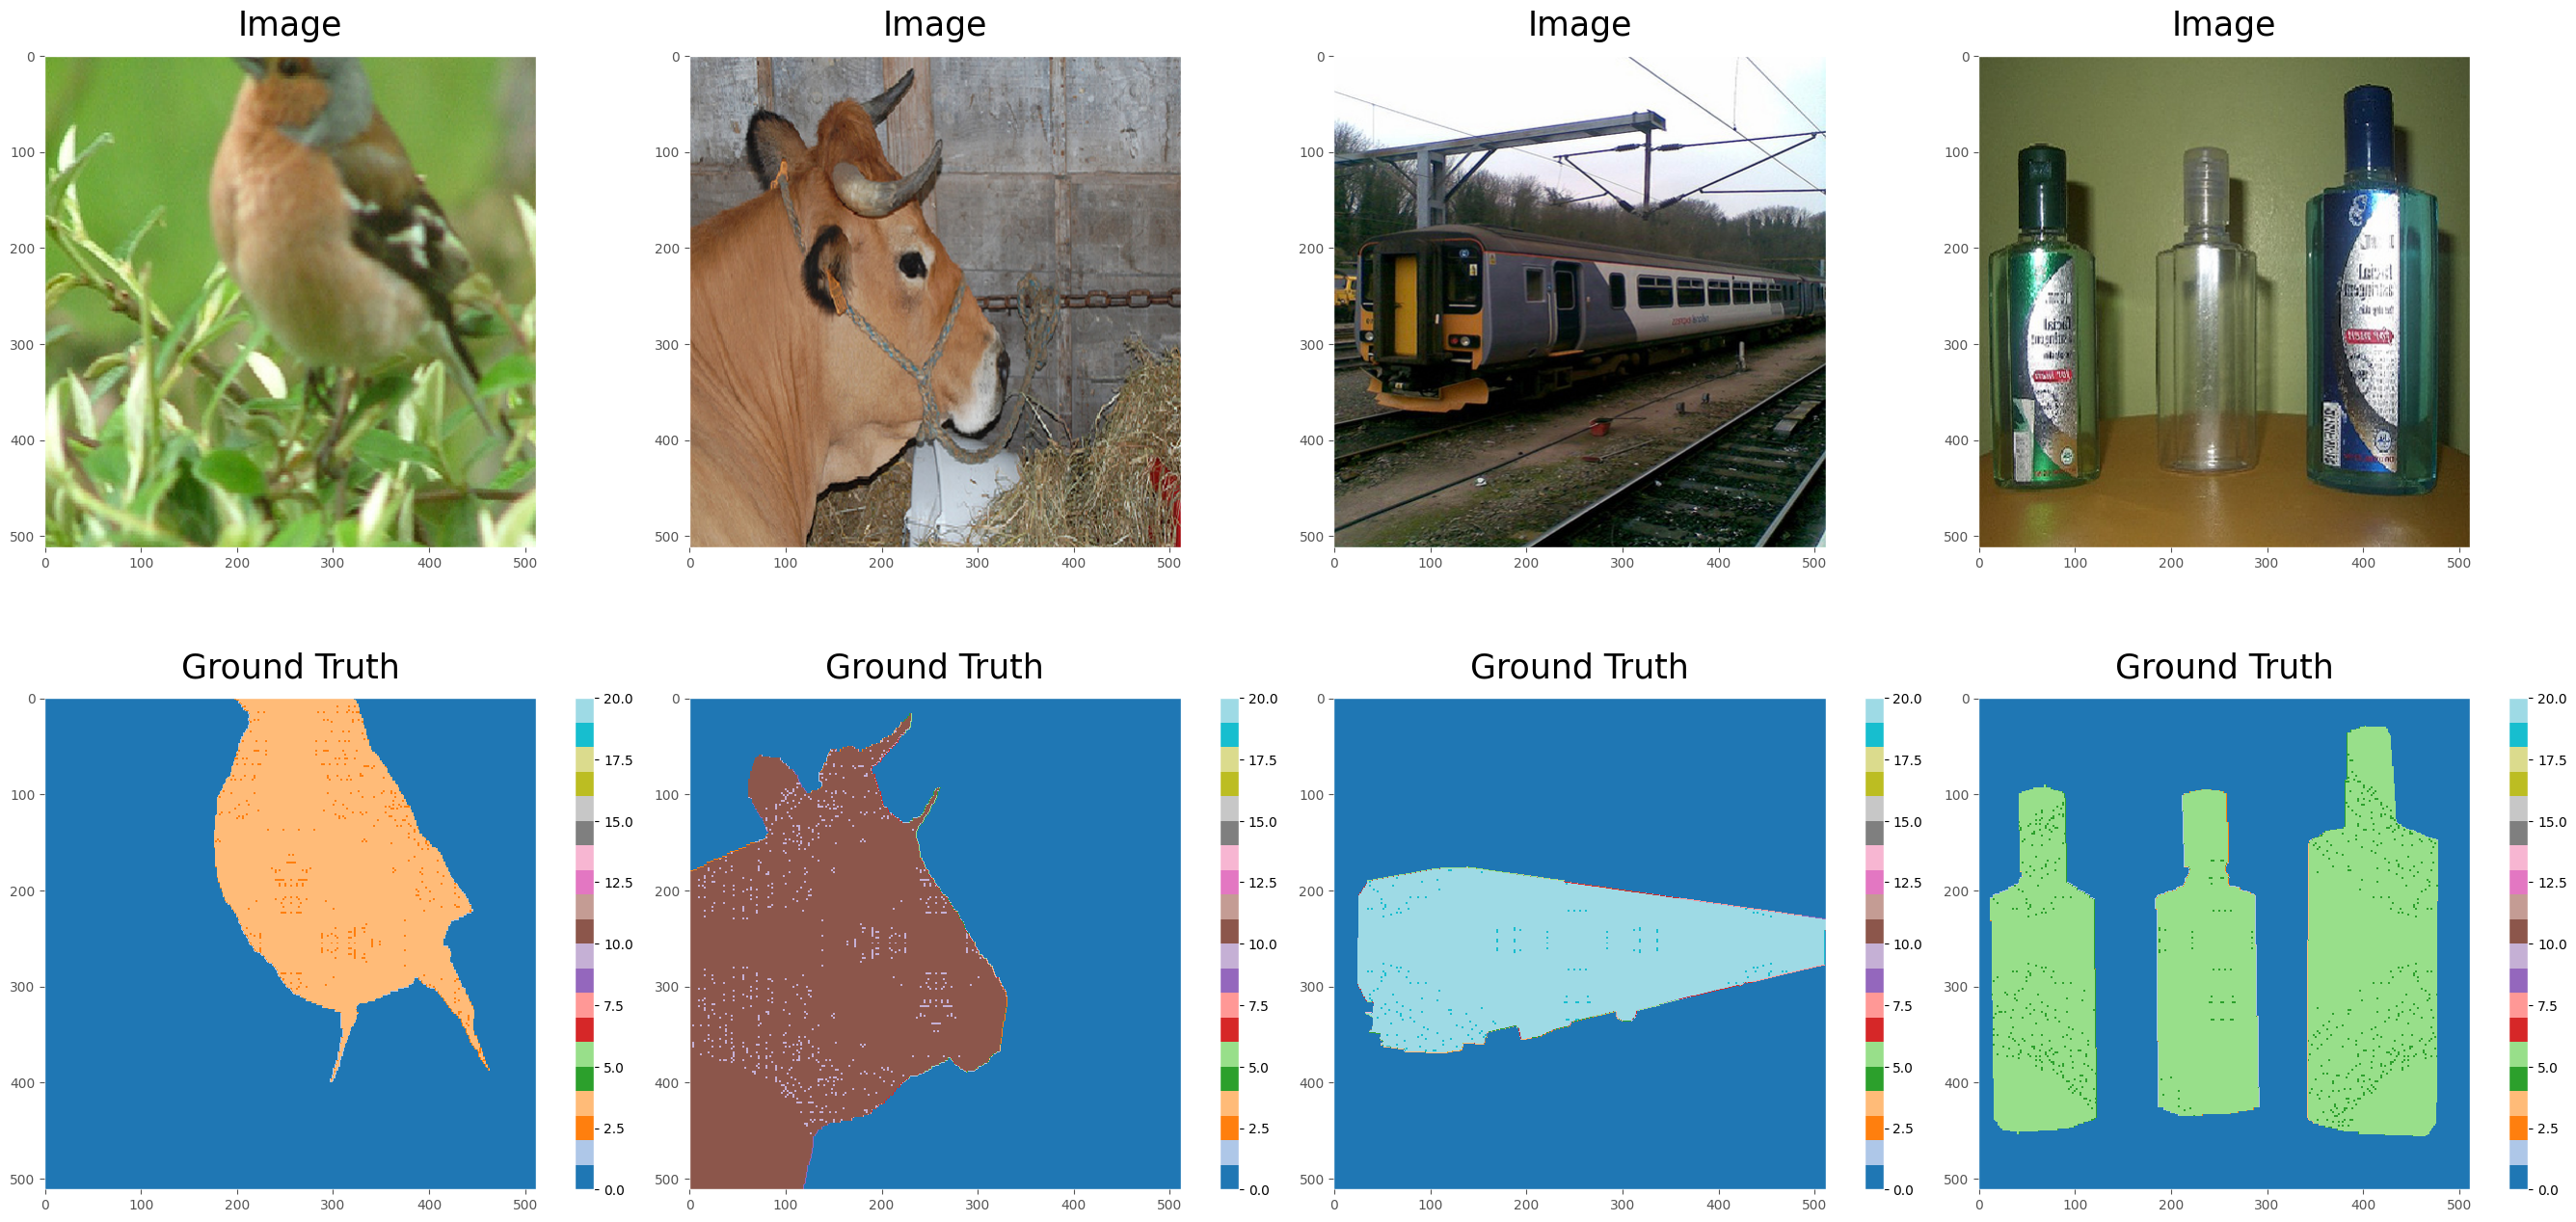

In [9]:
num_images = 4
batch = images_pipeline.next_batch(num_images, shuffle=True)
images = batch.images.transpose((0, 2, 3, 1))
masks = batch.train_labels
images_list = list(images)
masks_list = list(masks)
    
plot(images_list + masks_list,
     title=['Image'] * num_images + ['Ground Truth'] * num_images,
     combine='separate',
     cmap='tab20',
     nrows=2,
     colorbar=[False] * num_images + [True] * num_images,
     vmin=0, vmax=20
)

<a id='val_pipeline'></a>
## Validation pipeline definition 

Before the training stage, we need firstly to set the validation pipeline in order to control the quality during the training: 

In [10]:
metrics_pipeline = (
     Pipeline()
    .import_model('model', main_pipeline)
    .init_variable('metrics')
    .init_variable('predicted_masks')
    .init_variable('val_loss', [])
    .predict_model('model',
                   inputs=B('images'),
                   targets=B('train_labels'),
                   outputs=['predictions', 'loss'],
                   save_to=[B('predicted_masks', mode='w'), V('val_loss', mode='a')])
    .gather_metrics('segmentation',
                    targets=B('train_labels'),
                    predictions=B('predicted_masks'),
                    fmt='logits',
                    num_classes=dataset.num_classes,
                    axis=1, 
                    save_to=V('metrics', mode='u'))
)

val_pipeline = (load_pipeline + metrics_pipeline) << dataset.test

The validation pipeline imports the model from the training pipeline and defines the metrics counting via the **gather_metrics** method. Under the hood, this method computes the confusion matrix and allows one to evaluate the wanted metrics, e.g. **accuracy** or **Mean Intersection Over Union (mIoU)**.

<a id='train_stage'></a>
## Training stage

In our training loop, we will use `Notifier` in order to track the training and validation losses at each iteration. We can pass **notifier config** with wanted variables as arguments of the `run` method of our training pipeline.

In addition, `Notifier` allows one to get the resource utilization information about **GPU/CPU** memory. You can find more about **notifier** in the tracking [tutorial](https://github.com/analysiscenter/batchflow/blob/master/examples/07_tracking.ipynb).

So, let the training begin!

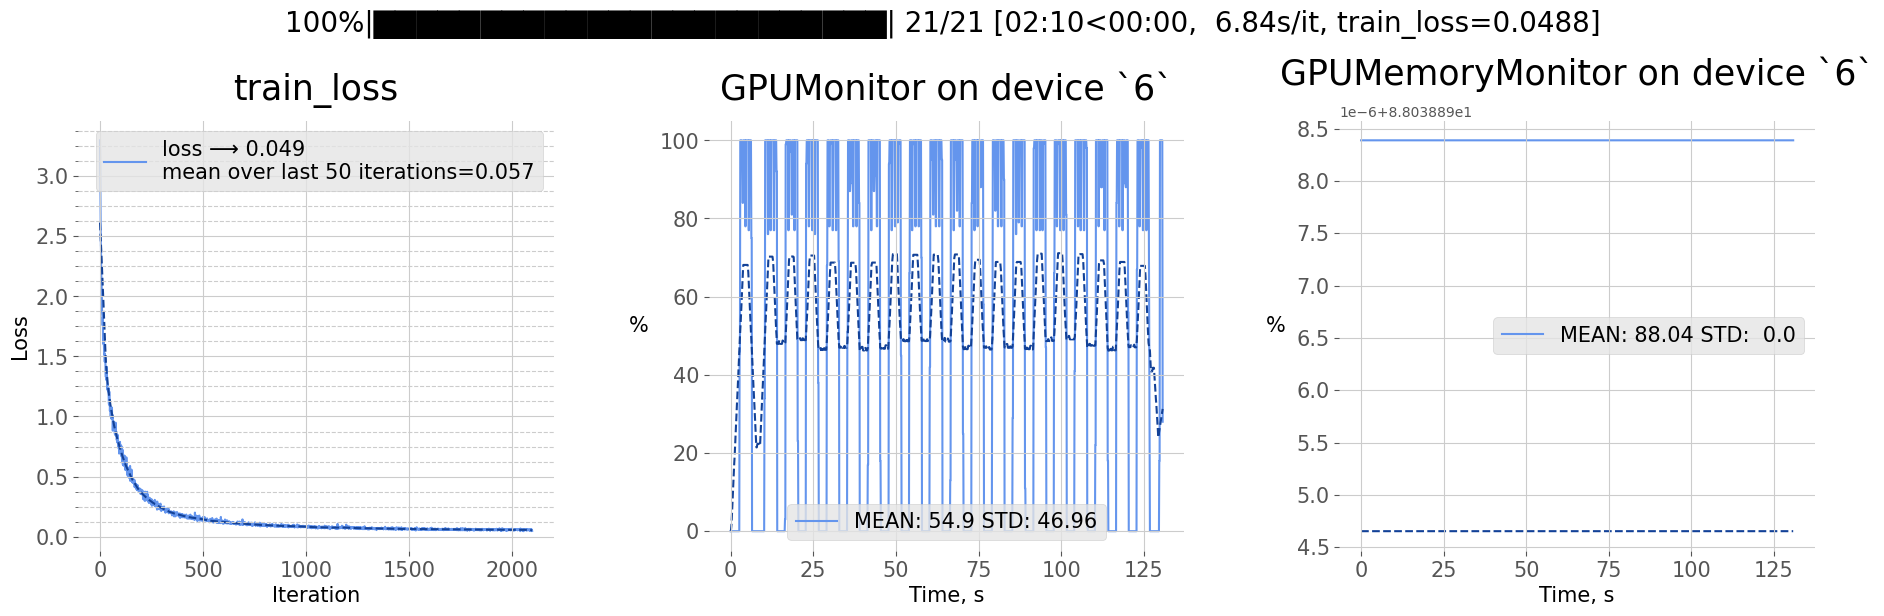

CPU times: user 3h 24min 17s, sys: 1h 1min 18s, total: 4h 25min 36s
Wall time: 4h 17min 3s


In [11]:
%%time
path = 'logs/deeplab_pretrained_change'
if not os.path.exists(path):
    os.makedirs(path)
    
val_loss_history = [np.nan] 
metrics_history = []
min_val_loss = np.inf 
train_loss_history = [np.nan]

train_notifier = {
    'bar': 'n',
    'frequency': FREQUENCY,
    'graphs': [
        {'source': 'train_loss'},
        {'source': 'gpu'},
        {'source': 'gpu_memory'},
    ],
    'savepath': os.path.join(path, 'notifier')
}

for _ in range(NUM_EPOCHS):
    main_pipeline.run(batch_size=BATCH_SIZE, n_epochs=1, shuffle=True, notifier=train_notifier)
    train_loss = main_pipeline.v('train_loss')[-len(dataset.train) // BATCH_SIZE:] 
    train_loss_history.append(np.mean(train_loss))
    
    val_pipeline.run(batch_size=BATCH_SIZE, drop_last=True, bar=None)
    iou = val_pipeline.v('metrics').evaluate('iou', agg='mean', multiclass='macro')
    metrics_history.append(iou)
    val_loss = val_pipeline.v('val_loss')[-len(dataset.test) // BATCH_SIZE:]
    val_loss_value = np.mean(val_loss)
    val_loss_history.append(val_loss_value)
    
    if val_loss_value < min_val_loss:
        main_pipeline.save_model_now('model', path='deeplab_pretrained_change_final.torch')
        min_val_loss = val_loss_value 

The training graphs show that loss function decreases and remains constant by the end of the training. Memory monitor shows that we use the GPU resources effectively.

We can also look at the train/val loss, learning rate and metrics after the training:

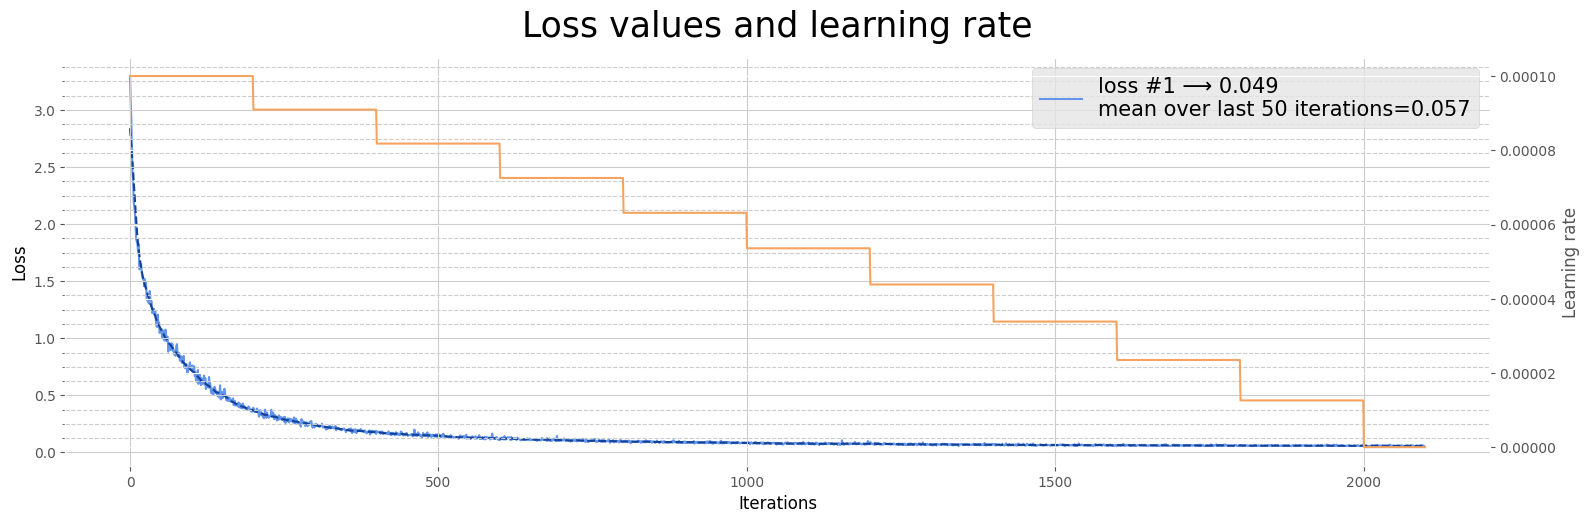

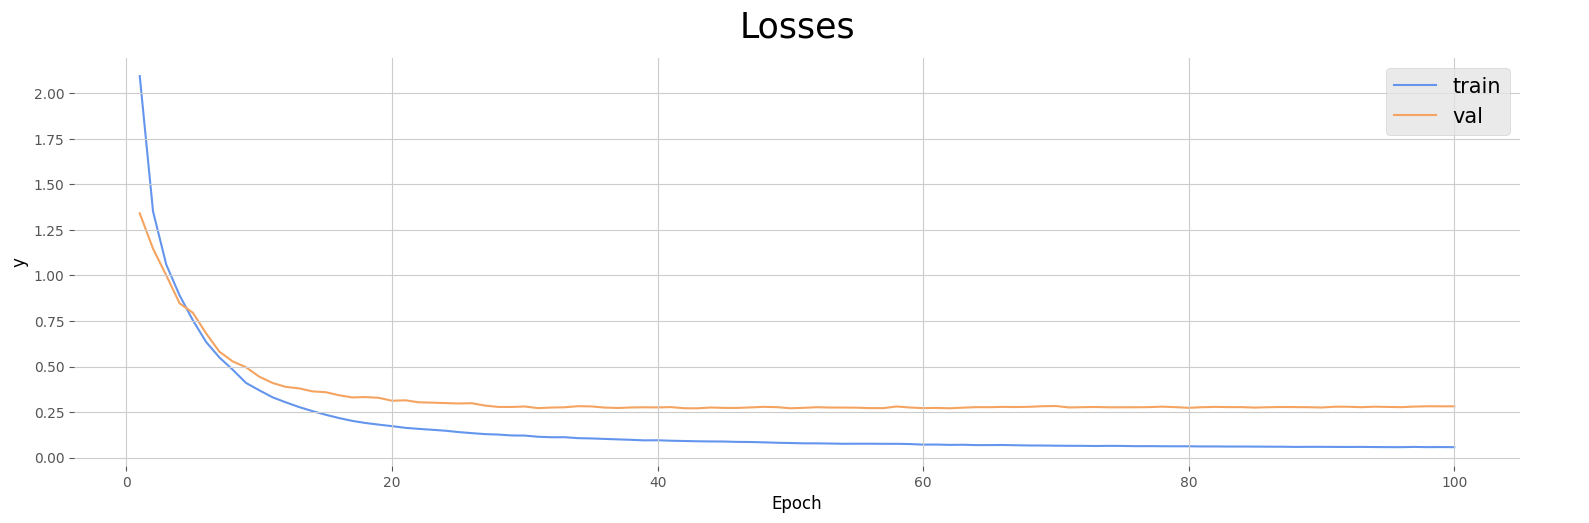

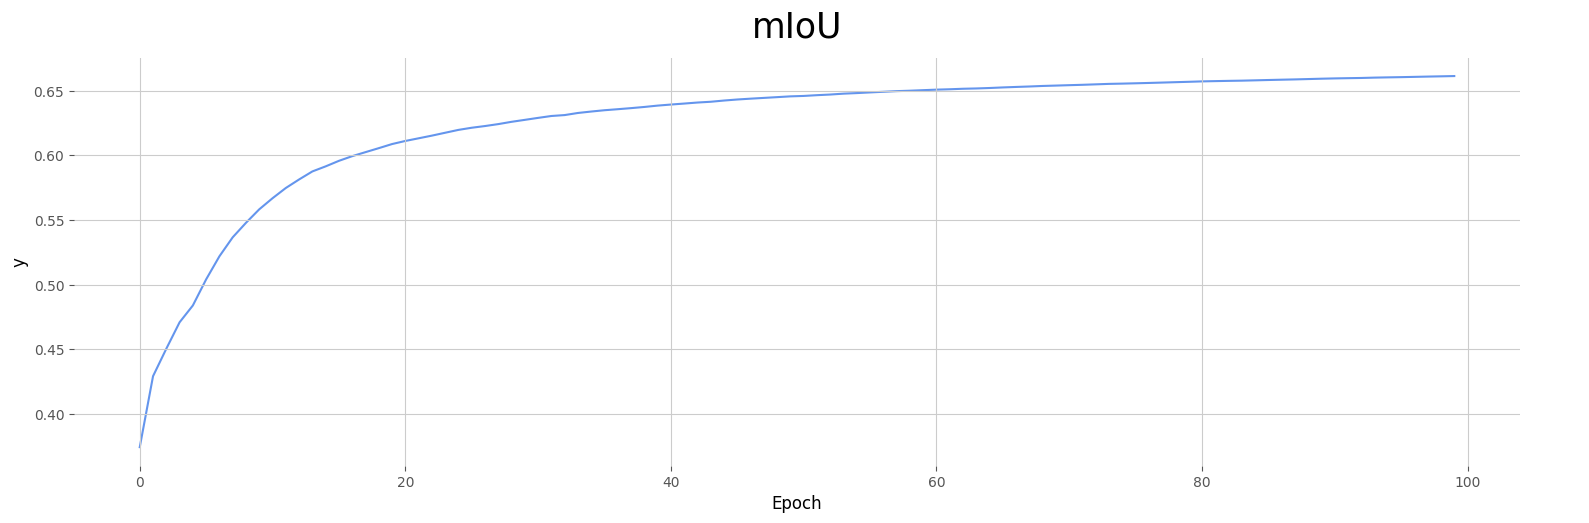

In [12]:
main_pipeline.model.plot_loss()
plot([train_loss_history, val_loss_history], mode='curve', xlabel='Epoch', label=['train', 'val'], title='Losses')
plot(metrics_history, mode='curve', xlabel='Epoch', title='mIoU')

The comparance of train/val losses suggests that there may be slight overfitting after the **~5 epoch**. However, validation mIoU continues to increase and goes to the plateue only by the end of the training. This indicates that our model hasn't stopped training after the **~5 epoch**.

<a id='inference'></a>
## Inference stage

At this stage, we will assess the quality of our model using the **mIoU**:

In [13]:
val_pipeline.run(batch_size=BATCH_SIZE, drop_last=False, bar='t')

IoU_micro = val_pipeline.v('metrics').evaluate('iou', agg='mean', multiclass='micro')
IoU_macro = val_pipeline.v('metrics').evaluate('iou', agg='mean', multiclass='macro')
IoU_per_class = val_pipeline.v('metrics').evaluate('iou', agg='mean', multiclass=None)

print(f'Micro mIoU: {IoU_micro:.3f}')
print(f'Macro mIoU: {IoU_macro:.3f}')

100%|█████████████████████████████████████████████| 3/3 [00:24<00:00,  8.26s/it]
Micro mIoU: 0.871
Macro mIoU: 0.662


Let's also look at the **per class mIoU**:

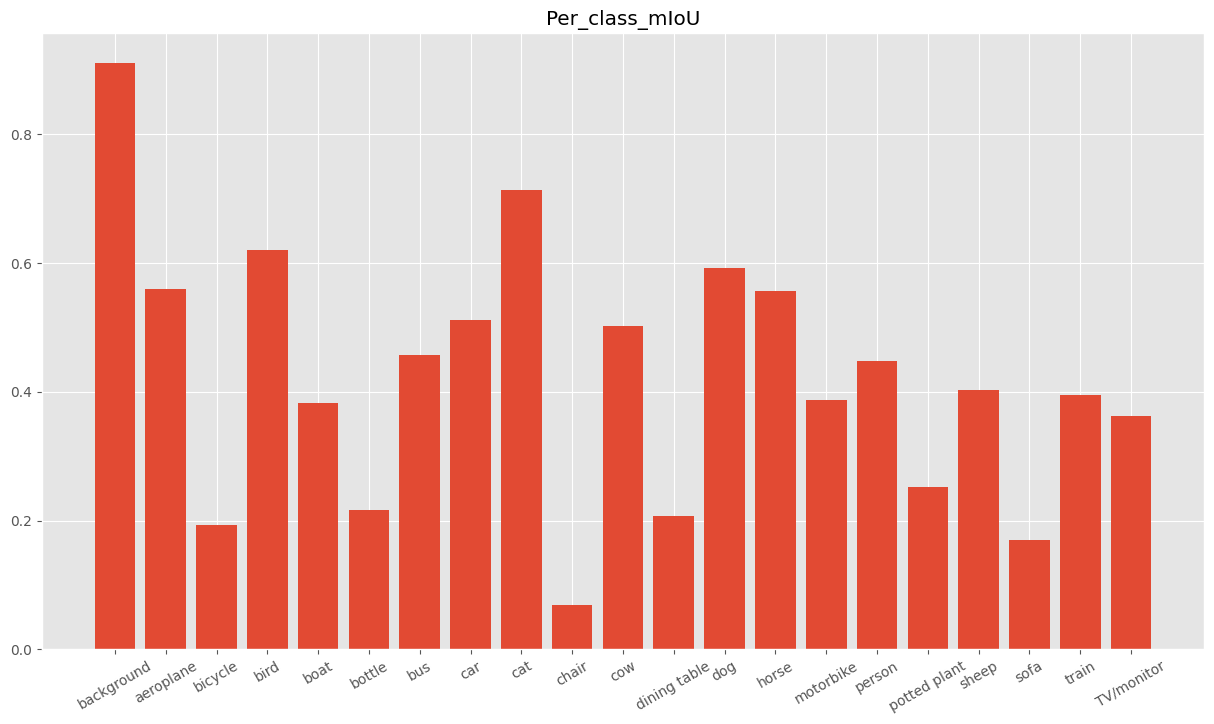

In [14]:
fig, ax = plt.subplots(figsize=(15, 8))
ax.bar(nonzero_labels[0][:-1], IoU_per_class)
ax.set_xticks(np.arange(21))
ax.set_xticklabels(dataset.classes, rotation=30)
ax.set_title('Per_class_mIoU')
plt.show()

Due to the background imbalance, we obtained the high **micro mIoU**, but if we look at the **per class mIoU**, we will see that background contributes the most in this metric. Therefore, the **macro mIoU** is more informative.

Perhaps you have a **question**: why in our case the **micro mIoU** is higher and not as informative as **macro** metrics?\
**Possible answer**: The **micro IoU** calculates statistics such as TP, FP, FN and **aggregates** the contributions from all classes, whereas the **macro IoU** computes the IoU **independently** for each class and then averages them. Therefore, the micro IoU will result in the overestimated results due to the high contribution by the background. 

However, if we solve a segmentation task, the most effective way to evaluate the quality of our model is to see the generated masks with your own eyes:  

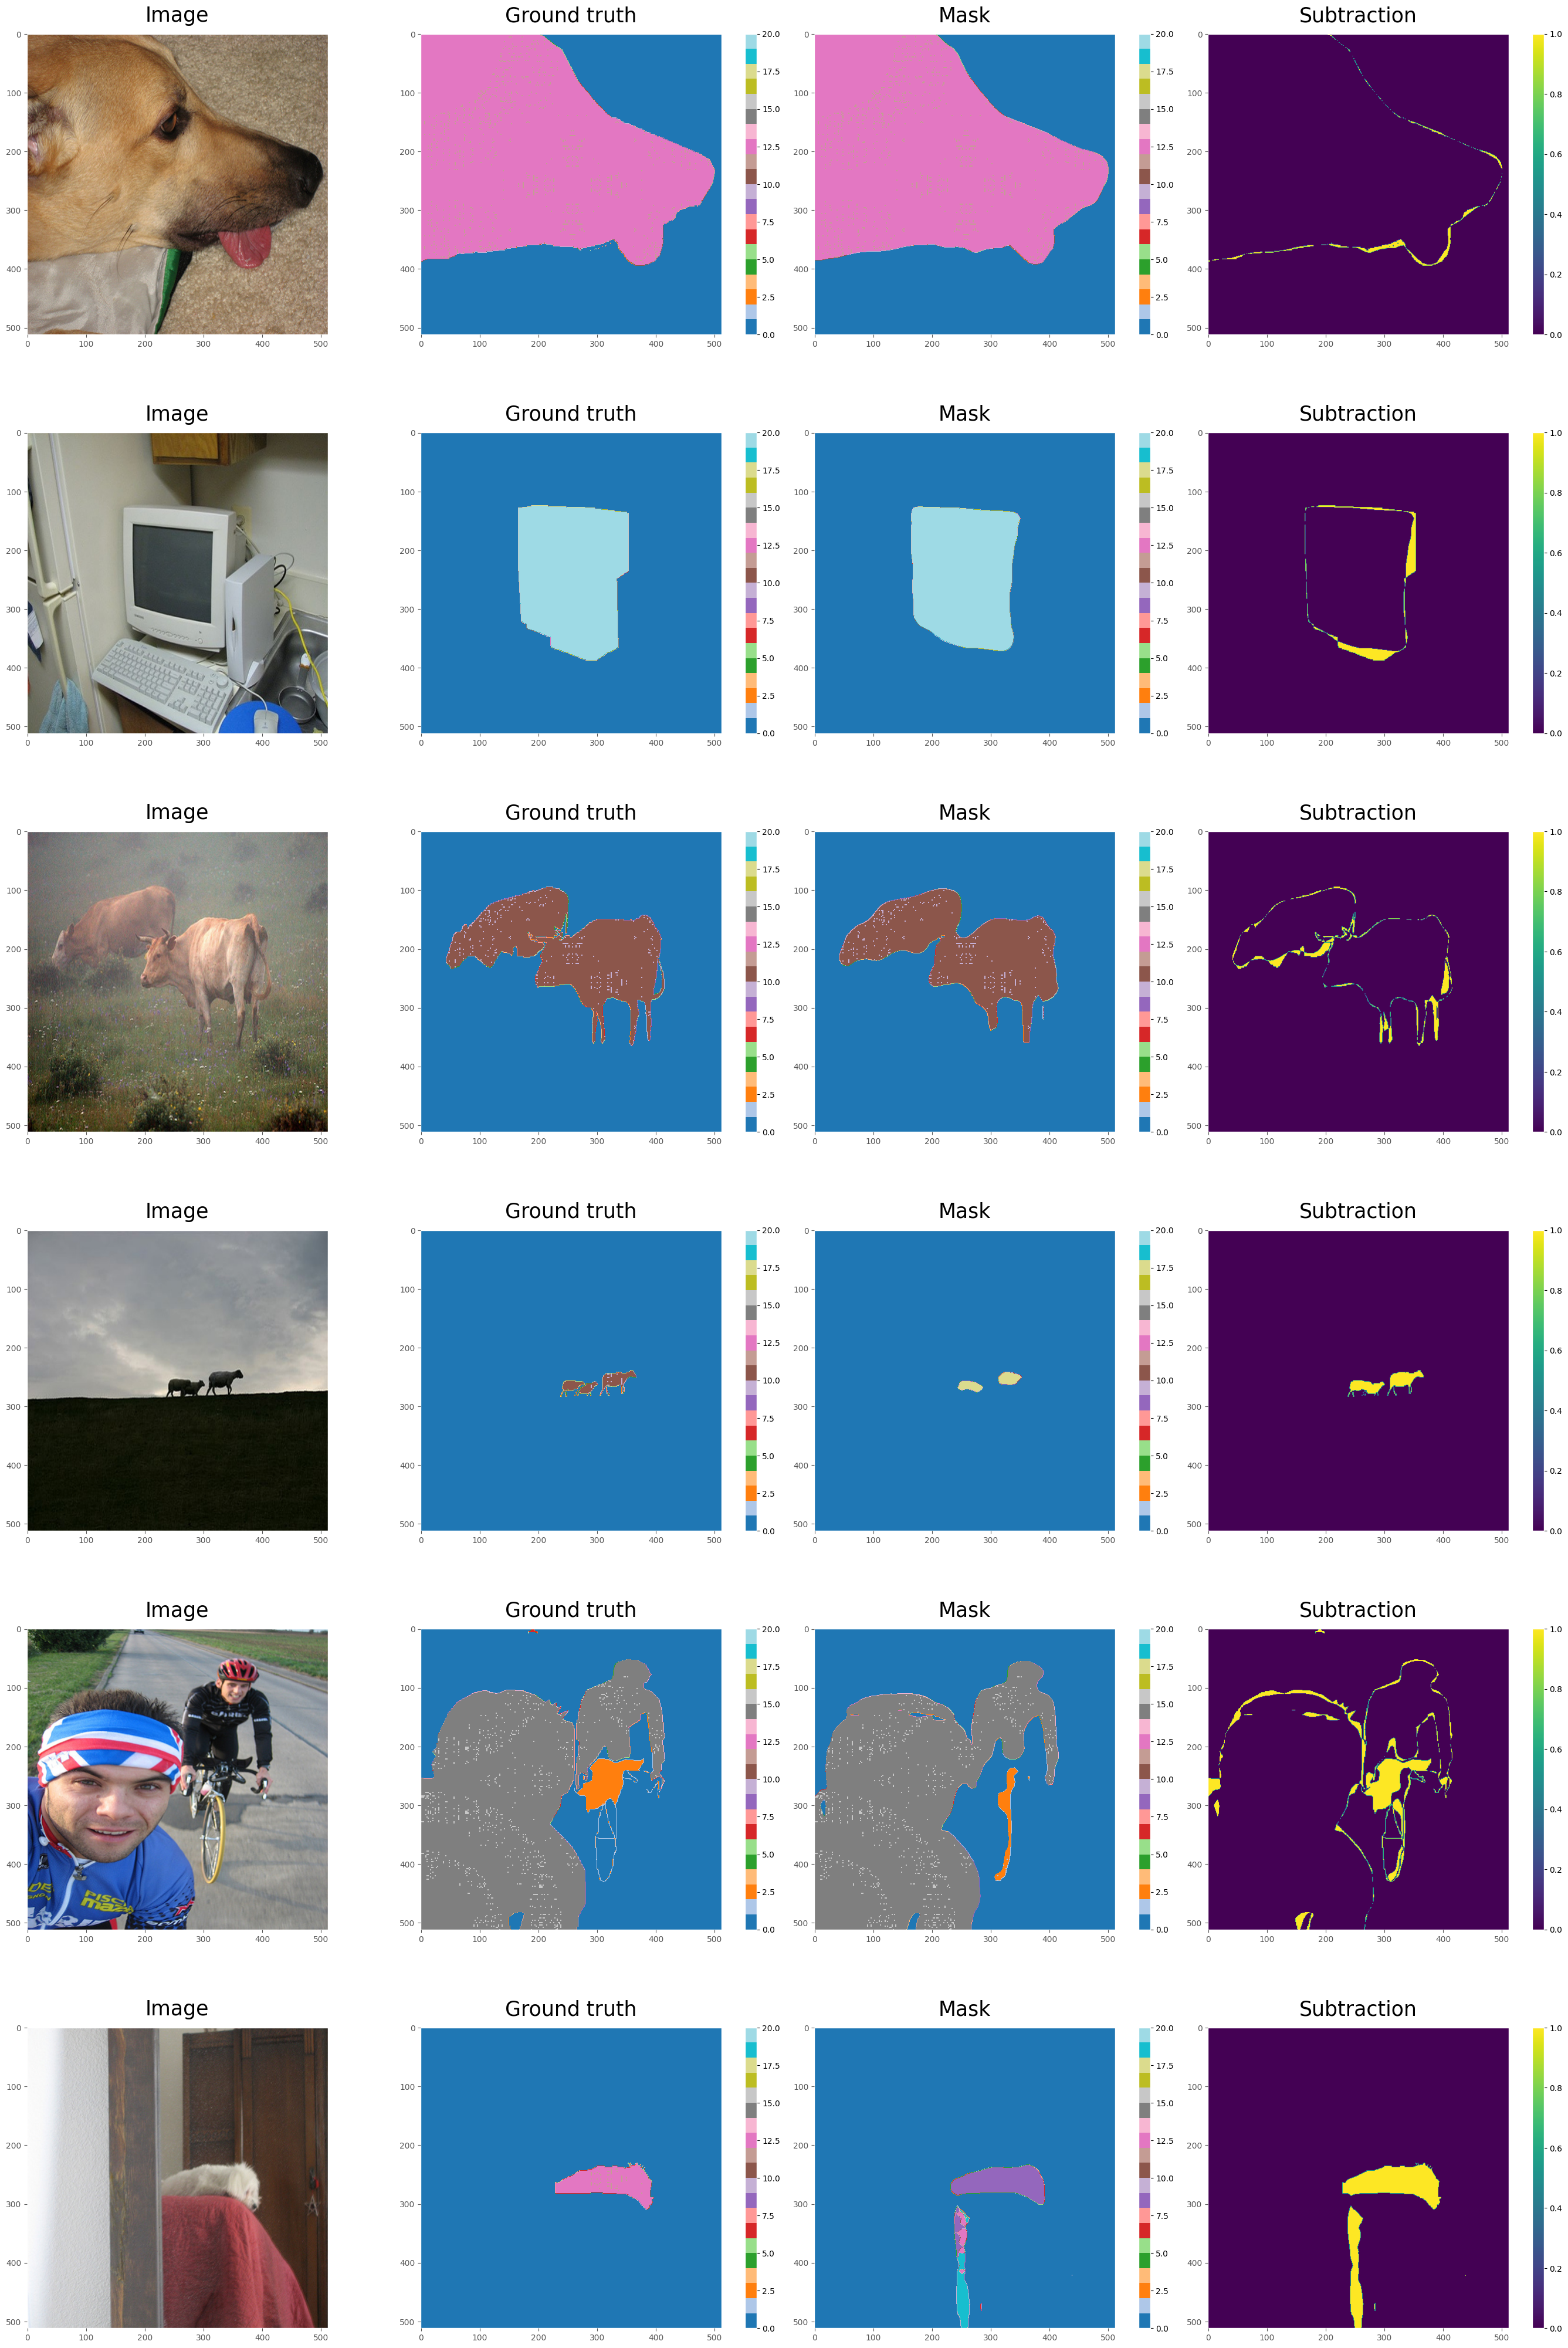

In [15]:
val_pipeline.reset('iter')
test_batch = val_pipeline.next_batch(6, shuffle=True)
images = test_batch.images
images = images.transpose((0, 2, 3, 1))
masks = test_batch.train_labels
predicted_masks = test_batch.predicted_masks.argmax(axis=1)
sub = predicted_masks - masks
sub[sub.nonzero()] = 1

all_images = []
num_images = len(images)

for imgs in zip(images, masks, predicted_masks, sub):
    all_images.extend(imgs)

plot(all_images,
     title=['Image', 'Ground truth', 'Mask', 'Subtraction'] * num_images,
     combine='separate',
     cmap=(['tab20'] * 3 + ['viridis']) * num_images,
     colorbar=[False, True, True, True] * num_images,
     ncols=4,
     vmin=0, vmax=([20] * 3 + [1]) * num_images
)

Well, the masks are good enough: mostly, the model finds locations of classes correctly and detects the true class without mismatches (except for few cases).

We can also visualize the confusion matrix and get information about the model mismatches: 

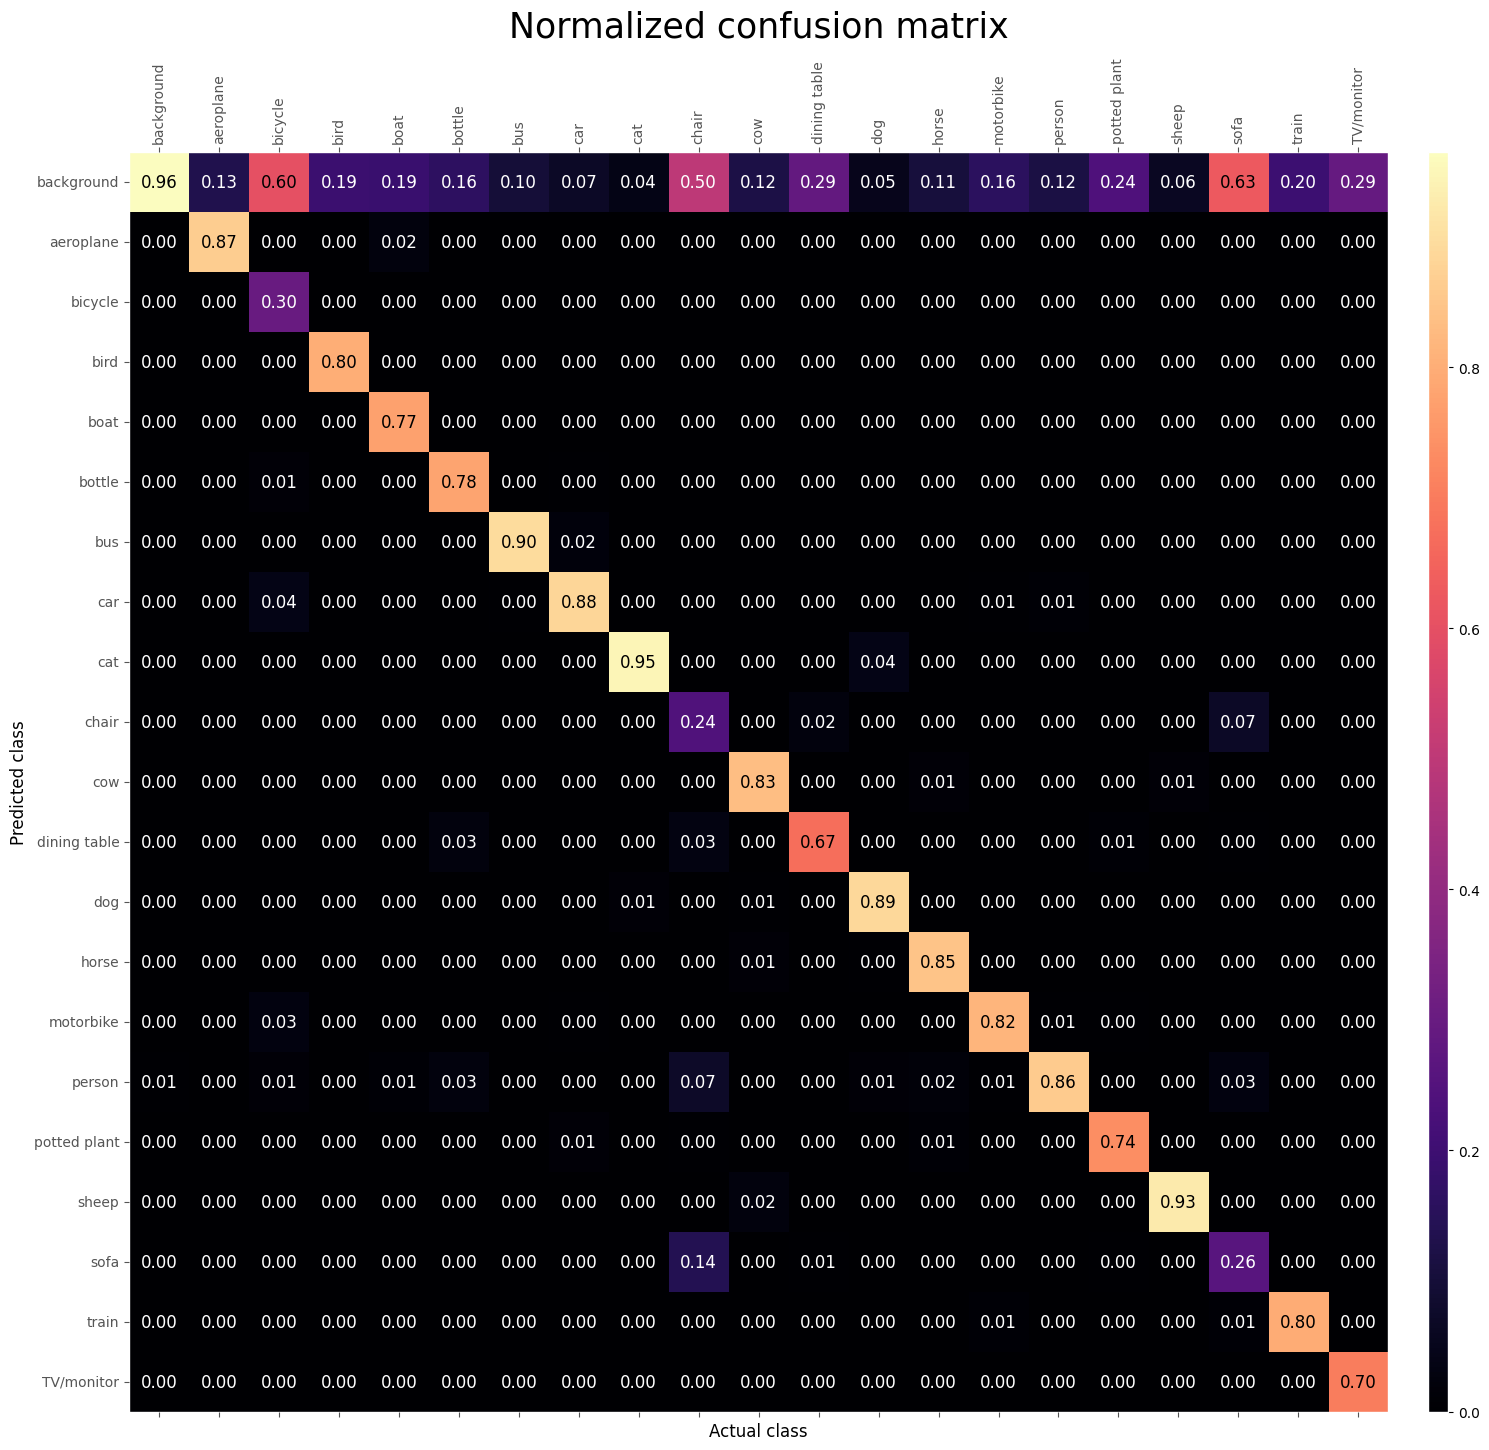

In [16]:
metrics = val_pipeline.v('metrics')
metrics.plot_confusion_matrix(classes=dataset.classes, normalize=True, figsize=(15, 15))

From the predicted masks and confusion matrix, we can conclude that model confuses some classes with the background more frequently, for example, bicycle. It's reasonable since a bicycle has few pixels compared to the background. Also, sometimes model finds other classes on the image even though they are not labeled on it. 

At a final point, let's check the quality of our code:

In [17]:
pylint_notebook()

Your code has been rated at 10.00/10 (previous run: 10.00/10, +0.00)
––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––


<a id='conclusion'></a>
## Conclusion

In this tutorial, we've learned how to solve the segmentation task with the BatchFlow library.
You can try out to improve our solution and get better results. But before it, we highly recommend you to read our previous [tutorials](https://github.com/analysiscenter/batchflow/tree/master/examples) including the classification tutorial.